In [1]:
# imports 

import gym
import numpy as np 
import pandas as pd 

# for capturing the video / graphs
import cv2 as cv
import matplotlib.pyplot as plt 


# for training nn:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim

# for truncated normal distribution
import scipy.stats as stats
import torch.distributions as distributions

# others
import os
import time


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3050 Laptop GPU


**env - CarRacing-v2**

**Policy-Gradients with critic**

(0,)


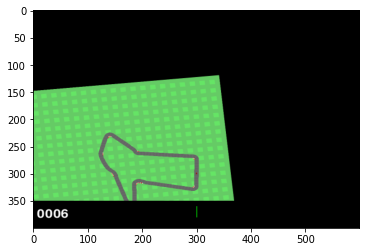

In [3]:
env = gym.make('CarRacing-v2',new_step_api='True',render_mode='rgb_array',continuous='False')
env.reset()
# example image
plt.imshow(np.array(env.render()).squeeze())
print(np.array(env.render()).shape)

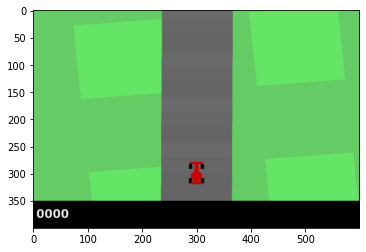

In [4]:
env.reset()
for i in range(55):
   env.step(np.array([0,0.0,0.0]))
plt.imshow(np.array(env.render()[-1]).squeeze())

<class 'numpy.ndarray'>


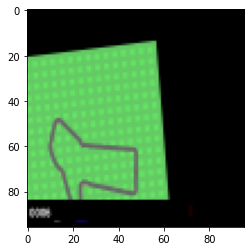

In [4]:
# This is our test img 
# With this img we are going to test some filters , so it will easier for our ML model to understand
test_img = env.step(np.array([0,0.2,0.0]))
print(type(test_img[0]))
test_img = test_img[0]
plt.imshow(test_img)

In [5]:
def filter_image(img):
    
    img = img[:-12,:]
    blank = np.zeros(img.shape)

    # applying some filters
    #print(img.shape)
    #img_gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    #img_edge =  cv.Canny(img_gray,100,150)

    # displaying the gray scale image
    '''plt.imshow(img_gray)
    plt.show()'''

    #size of image is high let's reduce some size:
    src = cv.resize(img, dsize =(84,96), interpolation = cv.INTER_AREA)
    img_edge_resized = cv.GaussianBlur(src,(3,3),cv.BORDER_DEFAULT)
    src = cv.resize(img_edge_resized, dsize =(50,50), interpolation = cv.INTER_AREA)
    img = cv.GaussianBlur(src,(3,3),cv.BORDER_DEFAULT)
    img_gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img_edge =  cv.Canny(img_gray,10,100)

    
    return img_edge

(50, 50)
(96, 96, 3)


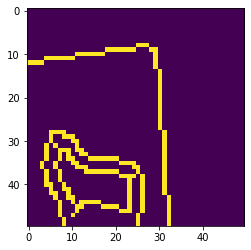

In [6]:
plt.imshow(filter_image(test_img))
print(filter_image(test_img).shape)
print(test_img.shape)
# d

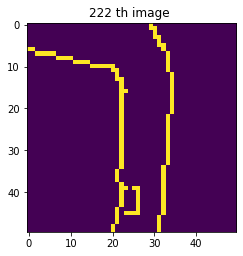

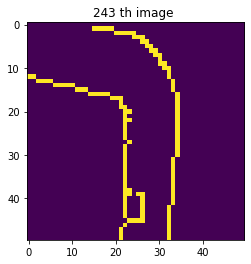

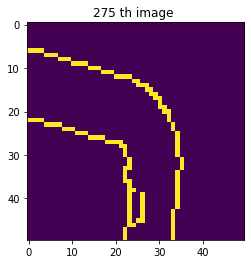

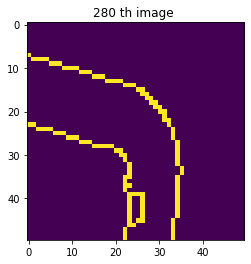

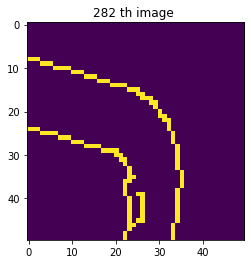

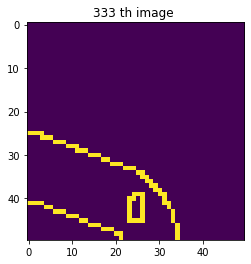

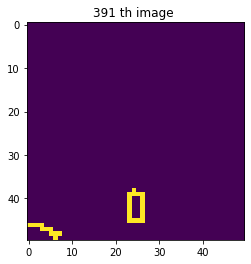

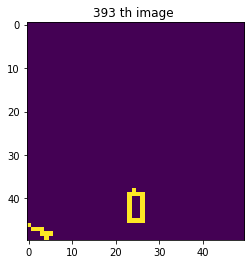

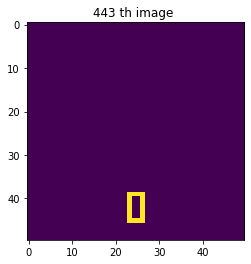

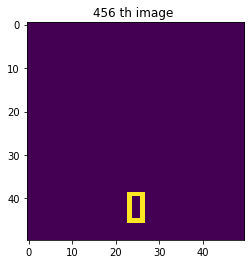

avg time : 0.0


'fig = plt.figure(figsize=(50,50))\nfor j,i in enumerate(np.random.randint(711,1000,(10))):\n    #print(images[i].shape)\n    fig.add_subplot(11,1,j+1)\n    plt.title(f"{i} th image ")\n    plt.imshow(filter_image(images[i]) )'

In [7]:
# only run this to see how the filter performs in various types of images.
# checking random samples:
time_taken = 0
env.reset()
a = np.array([-0.01,0.01,0])
fig = plt.figure(figsize=(50,50))
rand = np.random.randint(11,500,(10))
l=-1 
# images = np.zeros((1000,96,96,3)).astype(np.float32)

video_converter =  cv.VideoWriter_fourcc(*'mp4v')
test_video = cv.VideoWriter('./videos/test_video.avi',video_converter,30,(50,50))

for i in range(1000):
    #a = np.random.random((3)) # we can also use random vals
    d = env.step(a)
    filtered_img  = filter_image(d[0])
    #time_taken += t
    #frame = cv.cvtColor(filtered_img, cv.COLOR_GRAY2BGR)
    test_video.write(filtered_img)
    if i in rand:
        l =+ 1
        fig.add_subplot(11,1,l+1)
        plt.title(f"{i} th image ")
        plt.imshow(filtered_img)
        plt.show()
plt.show()
test_video.release()
print(f'avg time : {time_taken/1000}')

'''fig = plt.figure(figsize=(50,50))
for j,i in enumerate(np.random.randint(711,1000,(10))):
    #print(images[i].shape)
    fig.add_subplot(11,1,j+1)
    plt.title(f"{i} th image ")
    plt.imshow(filter_image(images[i]) )'''

In [9]:
# our model : # arch -2 

# arch - 1 : conv  : [0] - k(4,4) , p(1,1) , 1->32 ; [1] = k(4,4) , p(1,1) , 32->64 ; [2] = k(3,3) , p(1,1) , 64 -> 128 ; remaining else same
           # Actor - FNN : [1] : 512 -> 64 ; Critic-FNN : [1] = 256 -> 32

class A2C_Car_Racing(nn.Module):
    def __init__(self,prob_dist_params_dim = 6):

        super(A2C_Car_Racing,self).__init__()
        self.output = prob_dist_params_dim

        self.Common_Conv_layer = nn.Sequential(

            nn.Conv2d(1,16,kernel_size=(7,7),padding=0),   # img_size = ( size + 2*padding - kernel_size / stride ) + 1
            nn.MaxPool2d((2,2),stride=2),                  # img_size = ( ( size  - pool_size ) / stride ) + 1 
            nn.LeakyReLU(),
            # size = (22,22)                                

            nn.Conv2d(16,32,kernel_size=(3,3),padding=0),
            nn.MaxPool2d((2,2),stride=2),
            nn.LeakyReLU(),            
            # size = (10,10)

            nn.Conv2d(32,32,kernel_size=(3,3),padding=0), 
            nn.MaxPool2d((2,2),stride=2),
            nn.LeakyReLU(),
            # size = (4,4)

        )

        self.Actor_FNN = nn.Sequential(
            nn.Flatten(start_dim=0),
            nn.Linear(4*4*32,256),
            #nn.LeakyReLU(),
            #nn.Linear(256,32),
            #nn.LeakyReLU(),
            #nn.Linear(32,self.output),
        )

        self.Var = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(256,32),
            nn.ReLU(),
            nn.Linear(32,3),
            nn.Sigmoid(),
        )

        self.Mu = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(256,32),
            nn.LeakyReLU(),
            nn.Linear(32,2),
            nn.Sigmoid(),
        )

        self.Mu_1 = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(256,32),
            nn.LeakyReLU(),
            nn.Linear(32,1),
            nn.Tanh(),
        )

        self.Critic_FNN = nn.Sequential(
            nn.Flatten(start_dim=0),
            nn.Linear(4*4*32,128),
            nn.LeakyReLU(),
            nn.Linear(128,32),
            nn.LeakyReLU(),
            nn.Linear(32,1),
        )

    def forward(self,x):

        cnn_output = self.Common_Conv_layer(x) # passing img to conv layer
        
        # To calculate the value fn
        value = self.Critic_FNN(cnn_output)

        # To calculate the Mu and Variance
        prob_params = self.Actor_FNN(cnn_output)

        # Variance of 3 actions
        Variance = self.Var(prob_params)

        # Mu of 3 actions 
        Mu = self.Mu(prob_params)
        Mu_1 = self.Mu_1(prob_params)

        return value , Variance , Mu , Mu_1

In [10]:
# About Model
def about_model(model):
    print(model)
    print(f' total params in the model : {sum(p.numel() for p in model.parameters())}' )
    
about_model(A2C_Car_Racing())

A2C_Car_Racing(
  (Common_Conv_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): LeakyReLU(negative_slope=0.01)
  )
  (Actor_FNN): Sequential(
    (0): Flatten(start_dim=0, end_dim=-1)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (Var): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): Linear(in_features=256, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=3, bias=True)
    (4): Sigmoid()
  )
  (Mu): Sequential(
    (0)

In [112]:
from optparse import Values


class Car_racing():
    def __init__(self,name,env,lr=0.001,gamma=0.99,model=A2C_Car_Racing):

        self.name = name
        self.lr = lr
        self.gamma = gamma
        self.env = env
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.output_dim  = 6
        # our model will give the normal dist params for each action mu(mean) , sigma(sd)

        self.model = model(self.output_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=self.lr)

        ''' raise Exception(f"test-0 , checking model \n {self.model} ") - Passed '''
    
    def save_load_model(self,name,root_path,key='save'):
        path = os.path.join(root_path,f'{name}.pt')

        if os.path.exists(root_path):

            if key=='load':
                self.model.load_state_dict(torch.load(path,map_location=self.device))
                print('Model Successfully loaded')
            else:
                torch.save(self.model.state_dict(), path)
                print(f'The model named : {name} successfully saved')

        else:
            print(f'No such root_path {root_path} exists to load the model')


    def compute_returns(self,rewards,last_rew,gamma=0.99): # to compute the cumulative reward for the each state
        R = []
        cumulative_reward = last_rew
        rewards = torch.Tensor(rewards).to(self.device)

        for i in rewards:
            cumulative_reward = i + gamma*cumulative_reward
            R.insert(0,cumulative_reward)
        ''' raise Exception(f' Test -2 : \n test for checking the shape of the reward \n The reward length is : {len(R)} ') - passed '''
        return torch.cat(R).detach()
    

    def get_random_variates(self,Mu,Variance): # pass 2 np_array of size '3'

        # to get truncated normal dist in the range(-1,1) 
        # please visit the link https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html to get understanding of the formulae used 
    
        #np_array[1] , np_array[3] , np_array[5] , np_array[4] , np_array[2] = 1/(1+np.exp(-np_array[1])) + 1e-5 , 1/(1+np.exp(-np_array[3])) + 1e-5 , 1/(1+np.exp(-np_array[5])) + 1e-5 , 1/(1+np.exp(-np_array[4])) + 1e-5 , 1/(1+np.exp(-np_array[2])) + 1e-5

        action1_range1 , action1_range2 = ( -1 - Mu[0] ) / Variance[0] ,  ( 1 - Mu[0] ) / Variance[0] 
        action2_range1 , action2_range2 = (- Mu[1] ) / Variance[1] ,  ( 1 - Mu[1] ) / Variance[1]
        action3_range1 , action3_range2 = (- Mu[2] ) / Variance[2] ,  ( 1 - Mu[2] ) / Variance[2]
        
        # print(np_array,action1_range1 , action1_range2)

        action1 = stats.truncnorm.rvs(action1_range1 , action1_range2 , loc = Mu[0] , scale = Variance[0])
        action2 = stats.truncnorm.rvs(action2_range1 , action2_range2 , loc = Mu[1] , scale = Variance[1])
        action3 = stats.truncnorm.rvs(action3_range1 , action3_range2 , loc = Mu[2] , scale = Variance[2])

        actions = np.array([action1 , action2 , action3])

        ''' raise Exception(f" test -1 \n test for actions probs  \n The action taken now is {actions} \n The shape is {actions.shape} \n actions_params : {np_array}") # - Passed '''
        return actions


    def get_log_probs(self,actions,Mu,Variance):
        probs = []
        actions = torch.Tensor(actions).to(self.device)
        
        for i in range(3):
        
            D = distributions.Normal(loc = Mu[i] , scale = Variance[i])
            temp = torch.unsqueeze( D.log_prob( actions[i] ) , 0 )
            probs.append(temp)

        ''' raise Exception(f" test -3 \n test for log_prob values \n { ( torch.unsqueeze(probs[0],0) , torch.unsqueeze(probs[1],0), torch.unsqueeze(probs[2],0) ) }") # - Passed '''
        # print(probs)
        return torch.cat(probs).to(self.device)


    def train_A2C_Car(self,path,epochs,freq=10):
        reward_avg = []

        for e in range(epochs):
            state = self.env.reset(options={'randomize':False})
            # for storing log_probs , values of each state , rewards from each state / action
            rewards = []
            log_probs = []
            vals = []
            n = 2000
            r1 = 0

            for i in range(n):
                if i < 20:
                    continue

                state = filter_image(state)
                ''' raise Exception(f"Test-1 \n test for image dim , image dim = {state.shape}") -Passed '''

                state = torch.Tensor(state).to(self.device)
                state = torch.unsqueeze(state,0)
                value , Variance , Mu , Mu_1 = self.model(state)
                Mean = torch.cat((Mu_1,Mu),-1).requires_grad_()
                

                ''' raise Exception(f"{Mean} \n {Mu_1} \n {Mu} ") # - Passed ''' 

                # changing the params to numpy array
                Mu_numpy = Mean.detach().cpu().numpy()
                Var_numpy = Variance.detach().cpu().numpy()

                actions = self.get_random_variates(Mu_numpy,Var_numpy)
                next_state , r , done , _ , _ = env.step(actions)
                
                if r > 0.00:
                    #if r1 > 30:
                    #    print(r)
                    #    plt.imshow(next_state)
                    #    raise Exception(f" reward :{r} \n iters : {i}")
                    r = 10*r

                # changing current state 
                state = next_state

                # append rewards , values , log_probability
                rewards.append(r)
                vals.append(value)
                log_probs.append(self.get_log_probs(actions,Mean,Variance) )

                ''' raise Exception(f" log probs :  {log_probs[0]} ") # - Passed '''

                if done == True or i == n-1:
                    
                    state = filter_image(state)
                    state = torch.Tensor(state).to(self.device)
                    state = torch.unsqueeze(state,0)
                    
                    value ,_,_,_ =  self.model(state)
                    values =  torch.cat(vals)
                    log_probs = torch.cat(log_probs)

                    returns = self.compute_returns(rewards=rewards,last_rew=value)
                    advantage =  (returns - values)
                    
                    ''' raise Exception(f"Test-4 \n checking for grads \n grads for advantage : {advantage.requires_grad} \n grads for log_probs {log_probs.requires_grad} \n advantage size : {advantage.size()} {advantage[-1]}") # - Passed'''

                    # error terms 
                    critic_error = torch.mean(advantage.pow(2))
                    actor_error = torch.mean(-(log_probs * advantage.detach().unsqueeze(1) ) )


                    #print(f' printing grads of the network : {self.model.Actor_FNN[1].bias.grad} ')
                    ''' raise Exception(f" Test - 5 , \n checking the sizes of the error terms \n size of critic error : {critic_error.size} \n size of actor error : {actor_error} \n {log_probs.grad} {values.grad} ") # - passed '''

                    A2C_Loss = actor_error + critic_error
                    self.optimizer.zero_grad()

                    #values.retain_grad()
                    Mu.retain_grad()
                    Mu_1.retain_grad()
                    Mean.retain_grad()
                    Variance.retain_grad() 

                    A2C_Loss.backward()
                    self.optimizer.step()

                    # storing reward avg 
                    r_avg = sum(rewards)/len(rewards)
                    reward_avg.append(r_avg)

                    print(f'epoch {e} is finished and total iters : {i} ; done : {done}')
                    ''' raise Exception(f'printing grads of the Actor network[0] : {self.model.Actor_FNN[1].bias.grad.size()} \n printing kernels grad size : {self.model.Common_Conv_layer[0].weight.grad.size()}) \n grads of mean : {Mean.grad} \n {self.model.Critic_FNN[1].weight.grad.size()} \n ') # -Passed '''
                    break

            if (e+1)%freq == 0:
                print(f' printing kernels conv layer 1 : {self.model.Common_Conv_layer[0].weight[0]} ') # printing kernels of conv layer -1 
                print(reward_avg[-5:]) # printing last 5 rewards to get an idea whether our Ai is learning or not
                self.save_load_model(root_path = path , name=self.name , key='save')

        return reward_avg

    def train_model(self,save_freq=10,epochs=100,path='./weights/continuous actions space model weights',plot=False):

        name = self.name
        model_path = os.path.join(path,f'{name}.pt')

        if os.path.exists(model_path):
            self.save_load_model(root_path = path , key='load' , name=name)

        reward_history = self.train_A2C_Car(path=path,freq=save_freq,epochs=epochs)

        if plot:
            fig = plt.figure(10,10)
            plt.plot(reward_history,'b.')
            plt.xlabel('iters')
            plt.ylabel('rewards')
            plt.show()

        return reward_history


In [122]:
# Installing our model in this cell 

name = 'A2C_5_Car_Racing_V2_arch_2'
env = gym.make('CarRacing-v2',new_step_api='True',render_mode='rgb_array',continuous='True')
model1 = Car_racing(name=name,env=env)

In [123]:
# training our model here
reward_avg = model1.train_model(epochs=6,save_freq=2)

Model Successfully loaded
epoch 0 is finished and total iters : 1999 ; done : False
epoch 1 is finished and total iters : 1999 ; done : False
 printing kernels conv layer 1 : tensor([[[-0.1148, -0.1280,  0.0857, -0.0803,  0.0607,  0.1207, -0.1427],
         [ 0.1142, -0.1172,  0.1209,  0.0742, -0.1182,  0.1231, -0.0778],
         [ 0.0010,  0.0169,  0.1037, -0.1155, -0.0507,  0.0991, -0.0119],
         [-0.0698, -0.1222,  0.1147,  0.0640,  0.0128, -0.0698, -0.0360],
         [-0.0257, -0.1072,  0.0770, -0.0644, -0.1354,  0.1238, -0.0087],
         [-0.0509, -0.1417, -0.0398,  0.1165, -0.0344,  0.0364, -0.0748],
         [-0.0570,  0.1347,  0.1056, -0.1150,  0.0633, -0.0564,  0.0721]]],
       device='cuda:0', grad_fn=<SelectBackward0>) 
[-0.06787064190289682, 0.23575938597441984]
The model named : A2C_5_Car_Racing_V2_arch_2 successfully saved
epoch 2 is finished and total iters : 1265 ; done : True
epoch 3 is finished and total iters : 1999 ; done : False
 printing kernels conv layer 1

In [125]:
reward_avg

[-0.06787064190289682,
 0.23575938597441984,
 0.3344618349652971,
 0.1321618542325421,
 -0.06787064190289682,
 -0.06385668276972285]

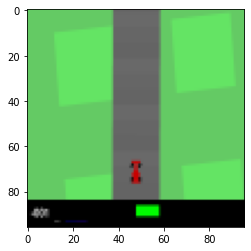

In [225]:
env.reset()
a = np.array([1.1,0.19,0.79])
for i in range(120):
    l = env.step(a)
plt.imshow(l[0])

In [14]:
with torch.no_grad():
    torch.cuda.empty_cache()
    !nvidia-smi

Sun Sep  4 19:26:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8    10W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
# solving some Random  doubts
a11 = torch.Tensor([[1,1,1],[1,1,1]])
b11 = torch.Tensor([2,2.5])
b11 = b11.unsqueeze(1)
c11 = a11 * b11
print(c11,b11.size(),a11.size(),c11.requires_grad)

tensor([[2.0000, 2.0000, 2.0000],
        [2.5000, 2.5000, 2.5000]]) torch.Size([2, 1]) torch.Size([2, 3]) False


In [97]:
stats.truncnorm.rvs(-9.8,-0.9,loc=10,size=10,scale=10)

array([-9.39806484, -1.28593938,  0.41388898, -2.60545658, -0.52821673,
       -2.46027318, -4.03593717, -1.24955684, -1.3143846 , -3.53631878])

In [97]:
env.reset()
n , r ,done , l , _ = env.step([0.1,0.1,0.2])
print(r,done,l,_ )

6.772852233676976 False False {}


In [127]:
t = [torch.Tensor( [[torch.Tensor([1]),torch.Tensor([1])]] ),torch.Tensor( [[torch.Tensor([1]),torch.Tensor([1])]] ) ]
t1 = torch.cat([t[0]])
print(t1)

tensor([[1., 1.]])


In [14]:
dist1 = distributions.Normal(loc = torch.Tensor([1]) , scale = torch.Tensor([1]))
k11 = dist1.log_prob(torch.tensor([1000]))
print(k11.requires_grad)

False


In [60]:
s,_,_,_,_ = env.step(np.array([0.1,0,0]))
s = filter_image(s)
s = torch.Tensor(s)
s = torch.unsqueeze(s,0)
print(s.size())

# clearing random doubts finished

torch.Size([1, 50, 50])


In [83]:
def get_random_variates(Mu,Variance): # pass np_array of size '6'

        # to get truncated normal dist in the range(-1,1) 
        # please visit the link https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html to get understanding of the formulae used 
    
        #np_array[1] , np_array[3] , np_array[5] , np_array[4] , np_array[2] = 1/(1+np.exp(-np_array[1])) + 1e-5 , 1/(1+np.exp(-np_array[3])) + 1e-5 , 1/(1+np.exp(-np_array[5])) + 1e-5 , 1/(1+np.exp(-np_array[4])) + 1e-5 , 1/(1+np.exp(-np_array[2])) + 1e-5

        action1_range1 , action1_range2 = ( -1 - Mu[0] ) / Variance[0] ,  ( 1 - Mu[0] ) / Variance[0] 
        action2_range1 , action2_range2 = (- Mu[1] ) / Variance[1] ,  ( 1 - Mu[1] ) / Variance[1]
        action3_range1 , action3_range2 = (- Mu[2] ) / Variance[2] ,  ( 1 - Mu[2] ) / Variance[2]
        
        # print(np_array,action1_range1 , action1_range2)

        action1 = stats.truncnorm.rvs(action1_range1 , action1_range2 , loc = Mu[0] , scale = Variance[0])
        action2 = stats.truncnorm.rvs(action2_range1 , action2_range2 , loc = Mu[1] , scale = Variance[1])
        action3 = stats.truncnorm.rvs(action3_range1 , action3_range2 , loc = Mu[2] , scale = Variance[2])

        actions = np.array([action1 , action2 , action3])

        ''' raise Exception(f" test -1 \n test for actions probs  \n The action taken now is {actions} \n The shape is {actions.shape} \n actions_params : {np_array}") # - Passed '''
        return actions

In [136]:
video_converter =  cv.VideoWriter_fourcc(*'mp4v')
video1 = cv.VideoWriter('./videos/A2C_car_racing-2-arch-3-video-2.avi',video_converter,30,(96,96))

In [137]:
def Enhance(agent,name,device):
  torch.no_grad()
  path = os.path.join('./weights/continuous actions space model weights',f'{name}.pt')
  agent.load_state_dict(torch.load(path,map_location=device))
  print(f'The model named : {name} successfully loaded')

In [140]:
def check_training(name):
  env = gym.make('CarRacing-v2',new_step_api='True',render_mode='rgb_array',continuous='True')
  torch.no_grad()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(device)

  agent = A2C_Car_Racing().to(device)
  done=False
  state = env.reset()
  i = 0
  j = 0
  rew = []
  Enhance(agent,name,device)

  while done!=True:
    if j == 200:
      plt.imshow(np.array(env.render())[-1])
      plt.show()
      #raise Exception(f" f ")
    if j < 200:
      j += 1
      continue
    state = filter_image(state)
    state = torch.Tensor(state).to(device)
    state = torch.unsqueeze(state,0)

    _, Variance , Mu , Mu_1 = agent(state)
    Mean = torch.cat((Mu_1,Mu),-1)
    print(Mean,Variance)

    Mu_numpy = Mean.detach().cpu().numpy()
    Var_numpy = Variance.detach().cpu().numpy()
    
    actions = get_random_variates(Mu_numpy,Var_numpy)
    d = env.step(actions)
    j+=1

    reward = d[1]
    next_state = d[0]
    done = d[2]
    
    #print(d)
    #raise Exception(' Test -1 to check the values ')
    #frame = cv.cvtColor(filter_image(d[0]))

    video1.write(d[0])
    state = next_state
    i+=1
    rew.append(reward)
    if done or i>500 :
        #print(rew)
        #prev_screen = env.render(mode='rgb_array')
        #plt.imshow(prev_screen)
        break

cuda
The model named : A2C_4_Car_Racing_V2_arch_2 successfully loaded


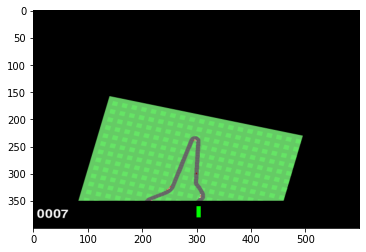

tensor([nan, nan, nan], device='cuda:0', grad_fn=<CatBackward0>) tensor([nan, nan, nan], device='cuda:0', grad_fn=<SigmoidBackward0>)


ValueError: Domain error in arguments.

In [141]:
for _ in range(1):
    check_training('A2C_4_Car_Racing_V2_arch_2')

In [135]:
video1.release()

In [143]:
def test():
    test_env = gym.make('CarRacing-v2',new_step_api='True',render_mode='rgb_array',continuous='True')
    env.reset(options={'randomize':False})
    done = False
    j = 0
    a = False

    video_converter =  cv.VideoWriter_fourcc(*'mp4v')
    video1 = cv.VideoWriter('./videos/testing-2.avi',video_converter,30,(96,96))

    while done != True and j < 400:

        actions = get_random_variates(np.array([-1,1,0.5,0.1,0,0.1]))
        a += (max(actions) > 1)
        temp = env.step(actions)
        done = temp[2]
        j+=1
        video1.write(temp[0])
    video1.release()
    print(a,done,j,temp[1:])
test()
# Use this fn to test env '''

False False 400 (-0.10000000000000009, False, False, {})
